In [26]:
import json, os, re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [17]:
with open("file_to_index.json", "r") as fp:
    file_index_dict = json.load(fp)

In [18]:
def get_times(extract_path, file_format_string):
    datapoints = []
    empty_files = 0
    for subdir, dirs, files, in os.walk(extract_path):
        for file in files:
            filepath = os.path.join(subdir, file)
            file_dict = json.load(open(filepath, "r"))
            idx = re.search(file_format_string, file).group(1)
            try:
                extract_time = file_dict['extract time']
                file_size = os.path.getsize(file_index_dict[idx])
                datapoints.append((file_size, extract_time))
            except KeyError:
                empty_files += 1
    
    return datapoints


In [19]:
datapoints = get_times("../../../CDIACMetadataExtract/CDIACImgExtract", "ImgXtract(.*).json") 

In [20]:
X = np.array([elem1 for elem1, elem2 in datapoints])
Y = np.array([elem2 for elem1, elem2 in datapoints])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=42)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1, 1)


In [21]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.000032 (0.000005)
ScaledLASSO: -0.000032 (0.000005)
ScaledEN: -0.000032 (0.000005)
ScaledKNN: -0.000038 (0.000007)
ScaledCART: -0.000077 (0.000010)
ScaledGBM: -0.000041 (0.000007)


In [28]:
model = LinearRegression()
RegressionPipeline = Pipeline([('Scaler', StandardScaler()), ('Regression', model)])
RegressionPipeline.fit(X_train, Y_train)


predictions = RegressionPipeline.predict(X_test)
print (mean_squared_error(Y_test, predictions))

3.071134443796169e-05


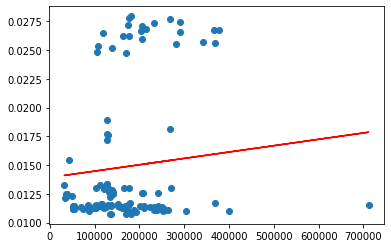

In [30]:
plt.scatter(X_test, Y_test)
plt.plot(X_test, predictions, color='red')
plt.show()